In [1]:
%load_ext autoreload
%autoreload 2

import torch
import esm
import pandas as pd
import numpy as np
from Functions import *

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt

# Load embeddings and make into csv

In [3]:
ref_spike_seq = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'

In [4]:
dms_results=decompress_pickle('./DMS/SARS-CoV-2_3B_S/S/representations/DMS_S.pbz.pbz2')

In [5]:
def extract_representations(dms_results,region):
    reps = []
    for key in dms_results[region].keys():
        rep = pd.DataFrame([key,dms_results[region][key]['logits'], dms_results[region][key]['embeddings']],index=['label','Logits','Mean_Embedding'])
        reps.append(rep)
    return pd.concat(reps,axis=1).T

In [6]:
dms_representations = extract_representations(dms_results,'S')
dms_representations

,label,Logits,Mean_Embedding
0,M1A,"[-5.0766172, -0.16323744, -0.23713367, -0.1357...","[-0.022825593, -0.019588226, 0.041874852, -0.0..."
0,M1R,"[-6.4560075, -0.17529452, -0.26826498, -0.1320...","[-0.02363167, -0.019951586, 0.04117015, -0.022..."
0,M1N,"[-8.19221, -0.1570628, -0.24539009, -0.1144290...","[-0.023776576, -0.019827412, 0.04165286, -0.02..."
0,M1D,"[-11.485312, -0.17618288, -0.25424558, -0.1179...","[-0.023752516, -0.019933408, 0.042045992, -0.0..."
0,M1C,"[-9.258609, -0.14413014, -0.25687778, -0.11161...","[-0.023793023, -0.019933283, 0.04184738, -0.02..."
...,...,...,...
0,T1273T,"[-0.000525694, -0.14445819, -0.25521517, -0.09...","[-0.023908686, -0.01997791, 0.041687366, -0.02..."
0,T1273W,"[-0.0004950728, -0.14596742, -0.2558382, -0.09...","[-0.023954742, -0.019994859, 0.041556835, -0.0..."
0,T1273Y,"[-0.0004898302, -0.14492525, -0.25613922, -0.0...","[-0.024032084, -0.01984282, 0.041260656, -0.02..."
0,T1273V,"[-0.0004757703, -0.14376152, -0.25448406, -0.0...","[-0.023665043, -0.01995269, 0.041718546, -0.02..."


In [7]:
dms_annotated = pd.read_csv('./DMS/DMS_S_annotated.csv')
dms_annotated

,label,semantic_score,relative_grammaticality,relative_sequence_grammaticality,relative_mutated_grammaticality,relative_masked_grammaticality,grammaticality,sequence_grammaticality,mutated_grammaticality,masked_grammaticality,...,subunit,domain,reference_amino_acid_property_basic,reference_amino_acid_property_complex,mutant_amino_acid_property_basic,mutant_amino_acid_property_complex,Accessibility WCN,Dissimilarity Charge Hydro,relative_grammaticality_with_eve,ESM-1b Relative Grammaticality with EVE
0,M1<mask>,0.280263,-27.088820,-25.328918,-2.576828e+01,-25.768278,-27.089346,-455.44275,-25.768805,-25.768805,...,S1,NTD,NaN,NaN,NaN,NaN,-1.736454,-0.109300,-4.913566,NaN
1,M1A,1.075221,-10.298975,-5.147125,-5.076092e+00,-9.141474,-10.299500,-435.26096,-5.076617,-9.141999,...,S1,NTD,nonpolar/hydrophobic,sulphur-containing,nonpolar/hydrophobic,aliphatic,-1.736454,-2.143469,-2.795214,-3.420387
2,M1C,0.633769,-11.712770,-9.324402,-9.258083e+00,-10.524997,-11.713296,-439.43823,-9.258609,-10.525522,...,S1,NTD,nonpolar/hydrophobic,sulphur-containing,polar/neutral,sulphur-containing,-1.736454,-1.756578,-2.879473,-3.734763
3,M1D,0.792559,-12.997172,-11.166962,-1.148479e+01,-11.687546,-12.997698,-441.28080,-11.485312,-11.688071,...,S1,NTD,nonpolar/hydrophobic,sulphur-containing,acidic,acidic,-1.736454,1.435655,-2.522970,-3.728455
4,M1E,0.580987,-12.931465,-11.689728,-1.188081e+01,-11.755999,-12.931991,-441.80356,-11.881338,-11.756524,...,S1,NTD,nonpolar/hydrophobic,sulphur-containing,acidic,acidic,-1.736454,1.251421,-2.537340,-3.627130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26728,T1273S,0.360495,-3.075783,0.386932,1.745711e-01,-2.186430,-3.734285,-429.72690,-0.483931,-2.844932,...,S2,CT,polar/neutral,hydroxylic,polar/neutral,hydroxylic,-1.736454,-2.014505,-2.153767,-2.198079
26729,T1273T,0.000000,0.000000,0.000031,-2.384186e-07,-2.628376,-0.658502,-430.11380,-0.658502,-3.286878,...,S2,CT,NaN,NaN,NaN,NaN,-1.736454,-0.109300,-1.650415,-1.535717
26730,T1273V,0.554940,-1.364866,-0.357819,4.543295e-01,-0.927641,-2.023368,-430.47165,-0.204173,-1.586143,...,S2,CT,polar/neutral,hydroxylic,nonpolar/hydrophobic,aliphatic,-1.736454,-0.835408,-1.833877,-1.975053
26731,T1273W,0.409149,-6.138748,-5.476044,-5.382471e+00,-5.446780,-6.797250,-435.58987,-6.040973,-6.105282,...,S2,CT,polar/neutral,hydroxylic,nonpolar/hydrophobic,aromatic,-1.736454,-1.148606,-2.196039,-2.512167


In [8]:
full_table = pd.merge(dms_annotated,dms_representations,how='left',left_on='label',right_on='label')
full_table = full_table[(full_table['label'].str.contains('mask') == False) & (full_table['ref']!= full_table['alt'])]
full_table

,label,semantic_score,relative_grammaticality,relative_sequence_grammaticality,relative_mutated_grammaticality,relative_masked_grammaticality,grammaticality,sequence_grammaticality,mutated_grammaticality,masked_grammaticality,...,reference_amino_acid_property_basic,reference_amino_acid_property_complex,mutant_amino_acid_property_basic,mutant_amino_acid_property_complex,Accessibility WCN,Dissimilarity Charge Hydro,relative_grammaticality_with_eve,ESM-1b Relative Grammaticality with EVE,Logits,Mean_Embedding
1,M1A,1.075221,-10.298975,-5.147125,-5.076092,-9.141474,-10.299500,-435.26096,-5.076617,-9.141999,...,nonpolar/hydrophobic,sulphur-containing,nonpolar/hydrophobic,aliphatic,-1.736454,-2.143469,-2.795214,-3.420387,"[-5.0766172, -0.16323744, -0.23713367, -0.1357...","[-0.022825593, -0.019588226, 0.041874852, -0.0..."
2,M1C,0.633769,-11.712770,-9.324402,-9.258083,-10.524997,-11.713296,-439.43823,-9.258609,-10.525522,...,nonpolar/hydrophobic,sulphur-containing,polar/neutral,sulphur-containing,-1.736454,-1.756578,-2.879473,-3.734763,"[-9.258609, -0.14413014, -0.25687778, -0.11161...","[-0.023793023, -0.019933283, 0.04184738, -0.02..."
3,M1D,0.792559,-12.997172,-11.166962,-11.484787,-11.687546,-12.997698,-441.28080,-11.485312,-11.688071,...,nonpolar/hydrophobic,sulphur-containing,acidic,acidic,-1.736454,1.435655,-2.522970,-3.728455,"[-11.485312, -0.17618288, -0.25424558, -0.1179...","[-0.023752516, -0.019933408, 0.042045992, -0.0..."
4,M1E,0.580987,-12.931465,-11.689728,-11.880813,-11.755999,-12.931991,-441.80356,-11.881338,-11.756524,...,nonpolar/hydrophobic,sulphur-containing,acidic,acidic,-1.736454,1.251421,-2.537340,-3.627130,"[-11.881338, -0.17300193, -0.2464024, -0.11872...","[-0.023779418, -0.019965893, 0.041948617, -0.0..."
5,M1F,1.102091,-9.100206,-4.701080,-4.502256,-7.948485,-9.100732,-434.81490,-4.502782,-7.949011,...,nonpolar/hydrophobic,sulphur-containing,nonpolar/hydrophobic,aromatic,-1.736454,-1.517074,-2.539038,-3.194983,"[-4.502782, -0.13539307, -0.22549607, -0.10435...","[-0.02301463, -0.020225096, 0.041624606, -0.02..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26727,T1273R,0.456232,-3.295858,0.095734,0.097451,-2.419800,-3.954360,-430.01810,-0.561051,-3.078302,...,polar/neutral,hydroxylic,basic,basic,-1.736454,2.614752,-1.470247,-1.520418,"[-0.00054690184, -0.14532232, -0.25572762, -0....","[-0.023948887, -0.019825358, 0.041546937, -0.0..."
26728,T1273S,0.360495,-3.075783,0.386932,0.174571,-2.186430,-3.734285,-429.72690,-0.483931,-2.844932,...,polar/neutral,hydroxylic,polar/neutral,hydroxylic,-1.736454,-2.014505,-2.153767,-2.198079,"[-0.00054249354, -0.14432633, -0.25564516, -0....","[-0.023909291, -0.019962087, 0.04180699, -0.02..."
26730,T1273V,0.554940,-1.364866,-0.357819,0.454329,-0.927641,-2.023368,-430.47165,-0.204173,-1.586143,...,polar/neutral,hydroxylic,nonpolar/hydrophobic,aliphatic,-1.736454,-0.835408,-1.833877,-1.975053,"[-0.0004757703, -0.14376152, -0.25448406, -0.0...","[-0.023665043, -0.01995269, 0.041718546, -0.02..."
26731,T1273W,0.409149,-6.138748,-5.476044,-5.382471,-5.446780,-6.797250,-435.58987,-6.040973,-6.105282,...,polar/neutral,hydroxylic,nonpolar/hydrophobic,aromatic,-1.736454,-1.148606,-2.196039,-2.512167,"[-0.0004950728, -0.14596742, -0.2558382, -0.09...","[-0.023954742, -0.019994859, 0.041556835, -0.0..."


In [9]:
def group_by_amino_acid(predictor,feature,table):
    position_table = table[['pos',predictor]].drop_duplicates('pos')
    amino_acids = np.sort(table.ref.unique())
    feature_dict = {}
    for position in position_table.pos:
        feature_set = []
        for amino_acid in amino_acids:
            amino_acid_feature = table[(table.pos == position) & (table.alt == amino_acid)]
            if len(amino_acid_feature) == 0:
                amino_acid_feature = 0
            else:
                amino_acid_feature = amino_acid_feature[feature].values[0]
                print(amino_acid_feature)
                if np.isnan(amino_acid_feature) == True:
                    amino_acid_feature = 0
            feature_set.append(amino_acid_feature)
        feature_dict[position] = feature_set
    df = pd.DataFrame(feature_dict).T
    df[feature] = df.values.tolist()
    df = df[[feature]]
    df = pd.merge(position_table,df,left_on='pos',right_index=True)
    return df



# Predictions

In [ ]:
features = ['semantic_score',
            'relative_grammaticality',
            'relative_sequence_grammaticality',
            'relative_grammaticality_with_eve',
            'grammaticality',
            'masked_grammaticality',
            'mutated_grammaticality',
            
            'Evescape Fitness','Evescape',

            'IND Mutability Score','DCA Mutability Score',

             'Mean_Embedding','Logits'
             ]

predictors = ['Accessibility','PSSM','ESST','Entropy','Escape','RBD Escape','Entry','Binding','RBD Wuhan-Hu-1 Binding','RBD Variant Average Binding','RBD Wuhan-Hu-1 Expression','RBD Variant Average Expression','ΔΔG','B-Factor']

In [ ]:
linear_best_predictor_results = []
new = True
for predictor in predictors:
    print('--------------------------------'+predictor.upper()+'--------------------------------')
    if predictor !='Entropy':
        data = full_table[full_table[predictor].isna() == False]
    else:
        data = full_table[full_table[predictor] >0]

    for feature in features:
        
        print('--------------------------------'+feature.upper()+'--------------------------------')
       
        if feature == 'semantic_score/relative_sequence_grammaticality':
            X = np.array([[data.semantic_score.values[i],data.relative_sequence_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'semantic_score/relative grammaticality':
            X = np.array([[data.semantic_score.values[i],data.relative_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'semantic_score':
            X = np.array([[data.semantic_score.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'relative grammaticality':
            X = np.array([[data.relative_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        elif feature == 'relative_sequence_grammaticality':
            X = np.array([[data.relative_sequence_grammaticality.values[i]] for i in range(len(data.semantic_score.values))])
        if feature == 'IND Mutability Score' or feature == 'DCA Mutability Score' or feature == 'Evescape Fitness':
            X = data[data[feature].isna() == False]
            X =np.array(X[feature].to_list())
        else:
            X =np.array(data[feature].to_list())

        if predictor == 'Accessibility' or predictor == 'B-Factor' or predictor == 'Entropy' :
            if feature != 'Mean_Embedding' and feature != 'Logits':
                X = group_by_amino_acid(predictor,feature,data)
                X =np.array(list(X[feature]))

        y = data[predictor]
        
        train_size = 0.8
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        kf = RepeatedKFold(n_splits=5,n_repeats=3, random_state=2652124)
        for train_index , test_index in kf.split(X):
            X_train , X_test = X.iloc[train_index],X.iloc[test_index]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
            lin_preds = LinearRegression().fit(X_train, y_train).predict(X_test)
            lin_spearman = scipy.stats.spearmanr(y_test, lin_preds)
            linear_best_predictor_results.append(['Linear',lin_spearman.correlation,lin_spearman.pvalue])
            print(f'Linear:{lin_spearman}')
            
            scaler = StandardScaler()
            scaler = scaler.fit(X_train)
            scaled_Xtrain = scaler.transform(X_train)
            scaled_Xtest = scaler.transform(X_test)
            
            svr = SVR(kernel='rbf')
            svr.fit(scaled_Xtrain,np.ravel(y_train))
            svr_preds =svr.predict(scaled_Xtest)
            svr_spearman = scipy.stats.spearmanr(y_test, svr_preds)
            linear_best_predictor_results.append(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue])
            
            print(f'SVR:{svr_spearman}')
            #Write results to file
            if new != True:
                pd.DataFrame(['Linear',lin_spearman.correlation,lin_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
                pd.DataFrame(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
            else:
                pd.DataFrame(['Linear',lin_spearman.correlation,lin_spearman.pvalue,predictor,feature],index =['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', index=False,)
                pd.DataFrame(['SVR-RBF',svr_spearman.correlation,svr_spearman.pvalue,predictor,feature],index = ['model','correlation','pvalue','predictor','feature']).T.to_csv(
                    'DMS/Results/Regression/Model_Fitted_Correlations.csv', mode='a', index=False, header=False)
                new=False

--------------------------------ACCESSIBILITY--------------------------------
--------------------------------MEAN_EMBEDDING--------------------------------
Linear:SignificanceResult(statistic=0.8048066803154137, pvalue=0.0)


: 

: 

In [ ]:
import pandas as pd
linear_best_predictor_results_df = pd.read_csv('./DMS/Results/Regression/Model_Fitted_Correlations.csv')
linear_best_predictor_results_df

,model,correlation,pvalue,predictor,feature
0,Linear,0.351626,4.262614e-08,Accessibility,semantic_score
1,SVR-RBF,0.437295,3.683927e-12,Accessibility,semantic_score
2,Linear,0.370995,6.977704e-09,Accessibility,semantic_score
3,SVR-RBF,0.484418,7.074020e-15,Accessibility,semantic_score
4,Linear,0.300486,3.661337e-06,Accessibility,semantic_score
...,...,...,...,...,...
5455,SVR-RBF,0.794838,0.000000e+00,B-Factor,Logits
5456,Linear,0.778022,0.000000e+00,B-Factor,Logits
5457,SVR-RBF,0.791215,0.000000e+00,B-Factor,Logits
5458,Linear,0.785000,0.000000e+00,B-Factor,Logits


In [15]:
linear_subset = linear_best_predictor_results_df[linear_best_predictor_results_df.model == 'Linear'].drop('model',axis=1)

linear_avg_correlation = linear_subset[['feature','predictor','correlation']].groupby(['feature','predictor']).mean()
linear_avg_correlation.columns = ['mean_correlation']
linear_avg_correlation = linear_avg_correlation.reset_index()

linear_max_pvalue = linear_subset[['feature','predictor','pvalue']].groupby(['feature','predictor']).max()
linear_max_pvalue.columns = ['max_pvalue']
linear_max_pvalue = linear_max_pvalue.reset_index()

linear_expanded_best_pred_df = pd.merge(linear_subset,linear_avg_correlation,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
linear_expanded_best_pred_df = pd.merge(linear_expanded_best_pred_df,linear_max_pvalue,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
linear_expanded_best_pred_df['bonferroni_corrected_max_pvalue'] = linear_expanded_best_pred_df.max_pvalue*len(linear_expanded_best_pred_df.predictor.unique())
linear_expanded_best_pred_df['bonferroni_max_significant'] = [ '*' if p <0.05 else '' for p in linear_expanded_best_pred_df.bonferroni_corrected_max_pvalue]

linear_filtered_bar_data = linear_expanded_best_pred_df[linear_expanded_best_pred_df.bonferroni_max_significant=='*'][['feature','predictor','correlation','mean_correlation','bonferroni_corrected_max_pvalue','bonferroni_max_significant']].drop_duplicates()
linear_bar_data = linear_filtered_bar_data[['predictor','feature','mean_correlation']].drop_duplicates().pivot(index="predictor", columns="feature", values="mean_correlation")

<Axes: xlabel='predictor'>

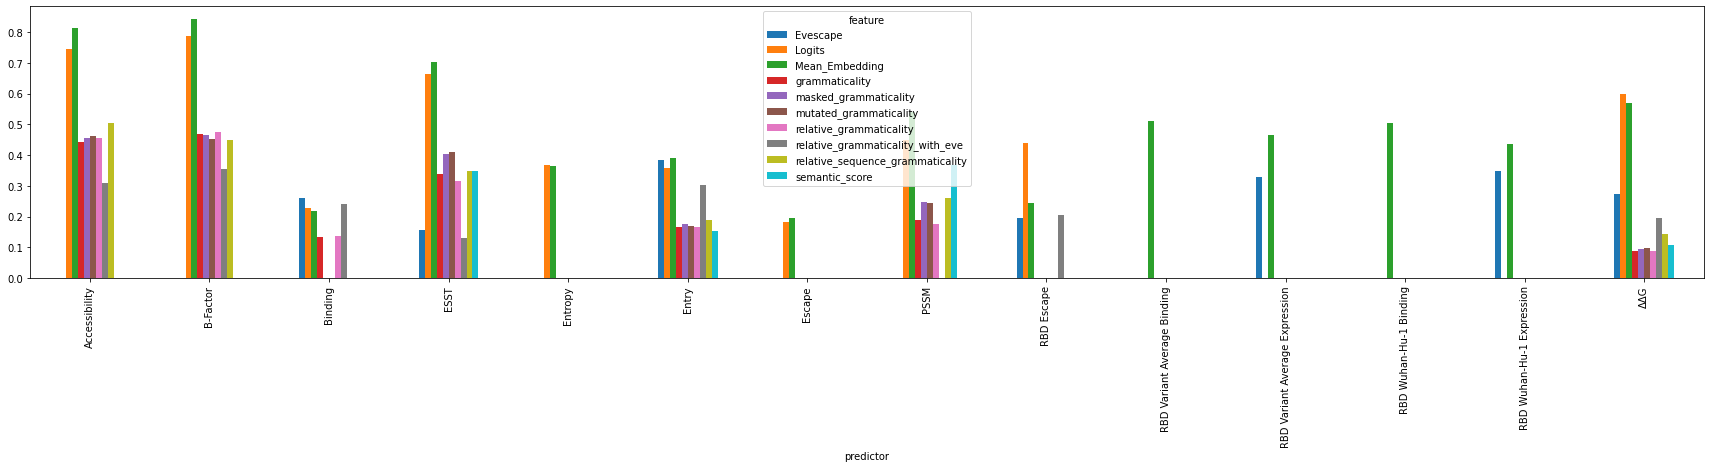

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[30,5])
linear_bar_data.plot(kind='bar',ax=ax)

In [17]:
svr_subset = linear_best_predictor_results_df[linear_best_predictor_results_df.model == 'SVR-RBF'].drop('model',axis=1)

svr_avg_correlation = svr_subset[['feature','predictor','correlation']].groupby(['feature','predictor']).mean()
svr_avg_correlation.columns = ['mean_correlation']
svr_avg_correlation = svr_avg_correlation.reset_index()

svr_max_pvalue = svr_subset[['feature','predictor','pvalue']].groupby(['feature','predictor']).max()
svr_max_pvalue.columns = ['max_pvalue']
svr_max_pvalue = svr_max_pvalue.reset_index()

svr_expanded_best_pred_df = pd.merge(svr_subset,svr_avg_correlation,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
svr_expanded_best_pred_df = pd.merge(svr_expanded_best_pred_df,svr_max_pvalue,how='left',left_on=['feature','predictor'],right_on=['feature','predictor'])
svr_expanded_best_pred_df['bonferroni_corrected_max_pvalue'] = svr_expanded_best_pred_df.max_pvalue*len(svr_expanded_best_pred_df.predictor.unique())
svr_expanded_best_pred_df['bonferroni_max_significant'] = [ '*' if p <0.05 else '' for p in svr_expanded_best_pred_df.bonferroni_corrected_max_pvalue]

svr_filtered_bar_data = svr_expanded_best_pred_df[svr_expanded_best_pred_df.bonferroni_max_significant=='*'][['feature','predictor','correlation','mean_correlation','bonferroni_corrected_max_pvalue']].drop_duplicates()

svr_bar_data = svr_filtered_bar_data[['predictor','feature','mean_correlation']].drop_duplicates().pivot(index="predictor", columns="feature", values="mean_correlation")

<Axes: xlabel='predictor'>

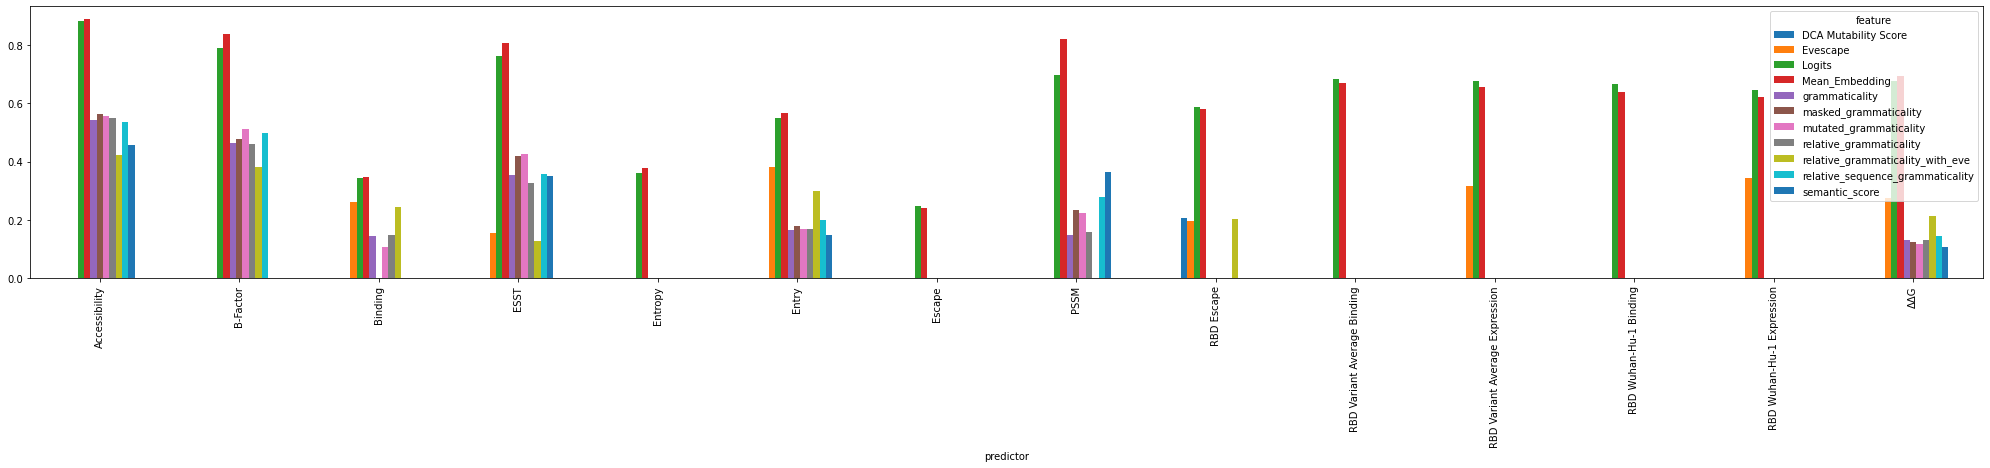

In [18]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[35,5])
svr_bar_data.plot(kind='bar',ax=ax)

# Single Value Correlations

In [ ]:
single_value_features = [
    'semantic_score',
    'relative_grammaticality',
    'relative_sequence_grammaticality',
    'relative_grammaticality_with_eve',
    'grammaticality',
    'masked_grammaticality',
    'mutated_grammaticality',

    'Evescape Fitness','Evescape',

    'IND Mutability Score','DCA Mutability Score',
        ]

In [20]:
single_value_correlations = []
for predictor in predictors:
    if predictor !='Entropy':
        data = full_table[full_table[predictor].isna() == False]
    else:
        data = full_table[full_table[predictor] >0]
    for feature in single_value_features:
        if feature == 'IND Mutability Score' or feature == 'DCA Mutability Score' or feature == 'Evescape Fitness':
            data = data[data[feature].isna() == False]
        single_value_correlations.append([feature,predictor,scipy.stats.spearmanr(data[feature], data[predictor]).correlation,scipy.stats.spearmanr(data[feature], data[predictor]).pvalue])
        

In [21]:
single_value_correlations_df = pd.DataFrame(single_value_correlations)
single_value_correlations_df.columns = ['feature','predictor','correlation','pvalue']
single_value_correlations_df['bonferroni_corrected_max_pvalue'] = single_value_correlations_df.pvalue*len(single_value_correlations_df.predictor.unique())
single_value_correlations_df['bonferroni_max_significant'] = [ '*' if p <0.05 else '' for p in single_value_correlations_df.bonferroni_corrected_max_pvalue]

In [22]:
single_value_correlations_df

,feature,predictor,correlation,pvalue,bonferroni_corrected_max_pvalue,bonferroni_max_significant
0,semantic_score,Accessibility,-0.053254,3.742140e-15,5.238996e-14,*
1,relative_grammaticality,Accessibility,0.243123,1.976906e-290,2.767668e-289,*
2,relative_sequence_grammaticality,Accessibility,0.240009,7.171211e-283,1.003970e-281,*
3,relative_grammaticality_with_eve,Accessibility,0.633656,0.000000e+00,0.000000e+00,*
4,grammaticality,Accessibility,0.244918,7.750857e-295,1.085120e-293,*
...,...,...,...,...,...,...
149,mutated_grammaticality,B-Factor,0.488721,0.000000e+00,0.000000e+00,*
150,Evescape Fitness,B-Factor,0.360085,0.000000e+00,0.000000e+00,*
151,Evescape,B-Factor,0.512165,0.000000e+00,0.000000e+00,*
152,IND Mutability Score,B-Factor,-0.001896,8.105629e-01,1.134788e+01,


In [23]:
linear_expanded_best_pred_df

,correlation,pvalue,predictor,feature,mean_correlation,max_pvalue,bonferroni_corrected_max_pvalue,bonferroni_max_significant
0,0.351626,4.262614e-08,Accessibility,semantic_score,0.296994,0.004541,0.063568,
1,0.370995,6.977704e-09,Accessibility,semantic_score,0.296994,0.004541,0.063568,
2,0.300486,3.661337e-06,Accessibility,semantic_score,0.296994,0.004541,0.063568,
3,0.187895,4.327354e-03,Accessibility,semantic_score,0.296994,0.004541,0.063568,
4,0.318466,8.582094e-07,Accessibility,semantic_score,0.296994,0.004541,0.063568,
...,...,...,...,...,...,...,...,...
2725,0.786051,0.000000e+00,B-Factor,Logits,0.786468,0.000000,0.000000,*
2726,0.781698,0.000000e+00,B-Factor,Logits,0.786468,0.000000,0.000000,*
2727,0.800210,0.000000e+00,B-Factor,Logits,0.786468,0.000000,0.000000,*
2728,0.778022,0.000000e+00,B-Factor,Logits,0.786468,0.000000,0.000000,*


In [24]:
filtered_single_value_correlations_df = single_value_correlations_df[single_value_correlations_df.bonferroni_max_significant=='*']

In [25]:
single_bar_data = filtered_single_value_correlations_df.drop_duplicates().pivot(index="predictor", columns="feature", values="correlation")

<Axes: xlabel='predictor'>

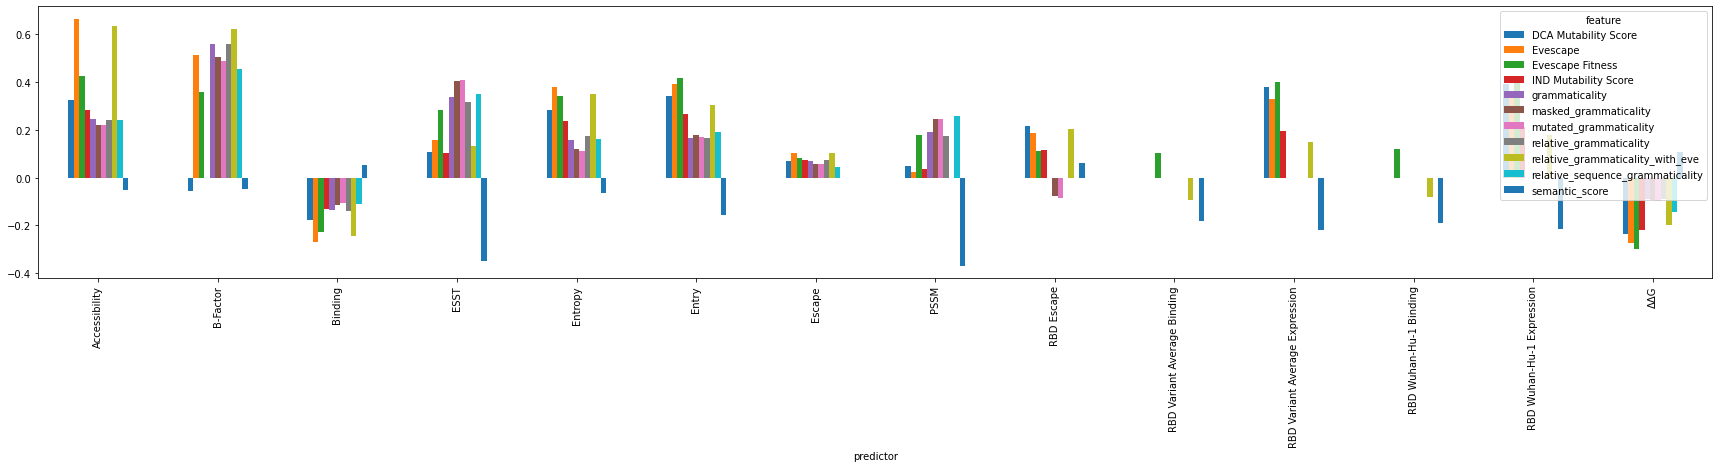

In [26]:
fig,ax = plt.subplots(figsize=[30,5])
single_bar_data.plot(kind='bar',ax=ax)

In [27]:
linear_best_predictor_results_df.predictor.unique()

array(['Accessibility', 'PSSM', 'ESST', 'Entropy', 'Escape', 'RBD Escape',
       'Entry', 'Binding', 'RBD Wuhan-Hu-1 Binding',
       'RBD Variant Average Binding', 'RBD Wuhan-Hu-1 Expression',
       'RBD Variant Average Expression', 'ΔΔG', 'B-Factor'], dtype=object)

In [28]:
single_value_correlations_df.predictor = single_value_correlations_df.predictor.replace({
    'Escape':'Escape Dadonaite et al. (2023)',
    'RBD Escape':'RBD Escape Yisimayi et al. (2024)',
    'Entry':'Entry Dadonaite et al. (2023)',
    'Binding':'Binding Dadonaite et al. (2023)',
    'RBD Wuhan-Hu-1 Binding':'RBD Wuhan-Hu-1 Binding Starr et al. (2022)',
    'RBD Variant Average Binding':'RBD Variant Average Binding Starr et al. (2022)',
    'RBD Wuhan-Hu-1 Expression':'RBD Wuhan-Hu-1 Expression Starr et al. (2022)',
    'RBD Variant Average Expression':'RBD Variant Average Expression Starr et al. (2022)',
    'Accessibility':'Accessibility BEpro',
    'ΔΔG':'ΔΔG FoldX',
    'B-Factor':'B-Factor PDB:6VXX',
    'PSSM':'PSSM DELTA-BLAST',
    'ESST':'ESST CRESCENDO',
    'Entropy':'Entropy Alignment'
})
linear_expanded_best_pred_df.predictor = linear_expanded_best_pred_df.predictor.replace({
    'Escape':'Escape Dadonaite et al. (2023)',
    'RBD Escape':'RBD Escape Yisimayi et al. (2024)',
    'Entry':'Entry Dadonaite et al. (2023)',
    'Binding':'Binding Dadonaite et al. (2023)',
    'RBD Wuhan-Hu-1 Binding':'RBD Wuhan-Hu-1 Binding Starr et al. (2022)',
    'RBD Variant Average Binding':'RBD Variant Average Binding Starr et al. (2022)',
    'RBD Wuhan-Hu-1 Expression':'RBD Wuhan-Hu-1 Expression Starr et al. (2022)',
    'RBD Variant Average Expression':'RBD Variant Average Expression Starr et al. (2022)',
    'Accessibility':'Accessibility BEpro',
    'ΔΔG':'ΔΔG FoldX',
    'B-Factor':'B-Factor PDB:6VXX',
    'PSSM':'PSSM DELTA-BLAST',
    'ESST':'ESST CRESCENDO',
    'Entropy':'Entropy Alignment'
})
svr_expanded_best_pred_df.predictor = svr_expanded_best_pred_df.predictor.replace({
    'Escape':'Escape Dadonaite et al. (2023)',
    'RBD Escape':'RBD Escape Yisimayi et al. (2024)',
    'Entry':'Entry Dadonaite et al. (2023)',
    'Binding':'Binding Dadonaite et al. (2023)',
    'RBD Wuhan-Hu-1 Binding':'RBD Wuhan-Hu-1 Binding Starr et al. (2022)',
    'RBD Variant Average Binding':'RBD Variant Average Binding Starr et al. (2022)',
    'RBD Wuhan-Hu-1 Expression':'RBD Wuhan-Hu-1 Expression Starr et al. (2022)',
    'RBD Variant Average Expression':'RBD Variant Average Expression Starr et al. (2022)',
    'Accessibility':'Accessibility BEpro',
    'ΔΔG':'ΔΔG FoldX',
    'B-Factor':'B-Factor PDB:6VXX',
    'PSSM':'PSSM DELTA-BLAST',
    'ESST':'ESST CRESCENDO',
    'Entropy':'Entropy Alignment'
})

In [29]:
single_value_correlations_df

,feature,predictor,correlation,pvalue,bonferroni_corrected_max_pvalue,bonferroni_max_significant
0,semantic_score,Accessibility BEpro,-0.053254,3.742140e-15,5.238996e-14,*
1,relative_grammaticality,Accessibility BEpro,0.243123,1.976906e-290,2.767668e-289,*
2,relative_sequence_grammaticality,Accessibility BEpro,0.240009,7.171211e-283,1.003970e-281,*
3,relative_grammaticality_with_eve,Accessibility BEpro,0.633656,0.000000e+00,0.000000e+00,*
4,grammaticality,Accessibility BEpro,0.244918,7.750857e-295,1.085120e-293,*
...,...,...,...,...,...,...
149,mutated_grammaticality,B-Factor PDB:6VXX,0.488721,0.000000e+00,0.000000e+00,*
150,Evescape Fitness,B-Factor PDB:6VXX,0.360085,0.000000e+00,0.000000e+00,*
151,Evescape,B-Factor PDB:6VXX,0.512165,0.000000e+00,0.000000e+00,*
152,IND Mutability Score,B-Factor PDB:6VXX,-0.001896,8.105629e-01,1.134788e+01,


In [30]:
single_value_correlations_df.to_csv('DMS/Results/Regression/expanded_single_value_correlations.csv')
linear_expanded_best_pred_df.to_csv('DMS/Results/Regression/expanded_linear_correlations_with_dms.csv')
svr_expanded_best_pred_df.to_csv('./DMS/Results/Regression/expanded_svr_correlations_with_dms.csv')

In [31]:
significant_linear_expanded_best_pred_df = linear_expanded_best_pred_df[linear_expanded_best_pred_df.bonferroni_max_significant == '*']
significant_svr_expanded_best_pred_df = svr_expanded_best_pred_df[svr_expanded_best_pred_df.bonferroni_max_significant == '*']
significant_single_value_correlations_df = single_value_correlations_df[single_value_correlations_df.bonferroni_max_significant == '*']

In [36]:
linear_expanded_best_pred_df['Model'] = 'Linear'
svr_expanded_best_pred_df['Model'] = 'SVR'
single_value_correlations_df['Model'] = 'Value'

all_sig_values = pd.concat([svr_expanded_best_pred_df,linear_expanded_best_pred_df,single_value_correlations_df]).drop(['bonferroni_corrected_max_pvalue','mean_correlation','max_pvalue','bonferroni_corrected_max_pvalue'],axis=1)
all_sig_values.feature = all_sig_values.feature.replace({'relative grammaticality':'relative_grammaticality'})
all_sig_values

,correlation,pvalue,predictor,feature,bonferroni_max_significant,Model
0,0.437295,3.683927e-12,Accessibility BEpro,semantic_score,*,SVR
1,0.484418,7.074020e-15,Accessibility BEpro,semantic_score,*,SVR
2,0.377527,3.599991e-09,Accessibility BEpro,semantic_score,*,SVR
3,0.327915,3.851645e-07,Accessibility BEpro,semantic_score,*,SVR
4,0.569959,3.985122e-21,Accessibility BEpro,semantic_score,*,SVR
...,...,...,...,...,...,...
149,0.488721,0.000000e+00,B-Factor PDB:6VXX,mutated_grammaticality,*,Value
150,0.360085,0.000000e+00,B-Factor PDB:6VXX,Evescape Fitness,*,Value
151,0.512165,0.000000e+00,B-Factor PDB:6VXX,Evescape,*,Value
152,-0.001896,8.105629e-01,B-Factor PDB:6VXX,IND Mutability Score,,Value


In [41]:
def method_annotation(column):
    method = []
    methods = {'ESM':['Mean_Embedding','Logits','semantic_score',
            'relative_grammaticality',
            'relative_sequence_grammaticality',
            'relative_grammaticality_with_eve',
            'grammaticality',
            'masked_grammaticality',
            'mutated_grammaticality',],
            'EVESCAPE':['Evescape Fitness','Evescape'],
            'Epistatic Models':['IND Mutability Score','DCA Mutability Score']
            }
    for c in column:
        if c in methods['ESM']:
            method.append('ESM')
        elif c in methods['EVESCAPE']:
            method.append('EVESCAPE')
        elif c in methods['Epistatic Models']:
            method.append('Epistatic Models')
        else:
            print(c)
    return method

In [42]:
all_sig_values['Method'] = method_annotation(all_sig_values.feature)
all_sig_values

,correlation,pvalue,predictor,feature,bonferroni_max_significant,Model,Method
0,0.437295,3.683927e-12,Accessibility BEpro,semantic_score,*,SVR,ESM
1,0.484418,7.074020e-15,Accessibility BEpro,semantic_score,*,SVR,ESM
2,0.377527,3.599991e-09,Accessibility BEpro,semantic_score,*,SVR,ESM
3,0.327915,3.851645e-07,Accessibility BEpro,semantic_score,*,SVR,ESM
4,0.569959,3.985122e-21,Accessibility BEpro,semantic_score,*,SVR,ESM
...,...,...,...,...,...,...,...
149,0.488721,0.000000e+00,B-Factor PDB:6VXX,mutated_grammaticality,*,Value,ESM
150,0.360085,0.000000e+00,B-Factor PDB:6VXX,Evescape Fitness,*,Value,EVESCAPE
151,0.512165,0.000000e+00,B-Factor PDB:6VXX,Evescape,*,Value,EVESCAPE
152,-0.001896,8.105629e-01,B-Factor PDB:6VXX,IND Mutability Score,,Value,Epistatic Models


In [43]:
significant_linear_expanded_best_pred_df.to_csv('DMS/Results/Regression/significant_linear_correlations_with_dms.csv')
significant_svr_expanded_best_pred_df.to_csv('DMS/Results/Regression/significant_svr_correlations_with_dms.csv')
significant_single_value_correlations_df.to_csv('DMS/Results/Regression/significant_single_value_correlations.csv')

In [44]:
all_sig_values.to_csv('DMS/Results/Regression/all_significant_correlations.csv')